Detection by elimination
===========================================
Let's show how to train object detectors using clasifiers

In [305]:
import scipy
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
import os
# Make sure that caffe is on the python path:
#caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
caffe_root = '/home/ubuntu/repositories/caffe/';
import sys
sys.path.insert(0, caffe_root + 'python')
import caffe
# Set the right path to your model definition file, pretrained model weights,
# and the image you would like to classify.

MODEL_FILE = os.path.join(caffe_root,'models/bvlc_reference_caffenet/deploy.prototxt')
PRETRAINED = os.path.join(caffe_root,'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel')
IMAGE_FILE = os.path.join(caffe_root,'examples/images/cat.jpg')

caffe.set_mode_gpu()
net = caffe.Net(MODEL_FILE, PRETRAINED,caffe.TEST)
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
meanImagePath = '/home/ubuntu/repositories/caffe/python/caffe/imagenet/ilsvrc_2012_mean.npy'
transformer.set_mean('data', np.load(meanImagePath	).mean(1).mean(1))
transformer.set_transpose('data', (2,0,1))
transformer.set_channel_swap('data', (2,1,0))
transformer.set_raw_scale('data', 255.0)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [306]:
input_image_orig = caffe.io.load_image(IMAGE_FILE)
img_size = input_image_orig.shape
print img_size

(360, 480, 3)


In [44]:
#rectangle(img, pt1, pt2, color[, thickness[, lineType[, shift]]]) -> None

In [307]:
def chunks(l, n):
    n = max(1, n)
    return [l[i:i + n] for i in range(0, len(l), n)]

In [405]:
def extractFC6(imagePaths):
    path_chunks = chunks(imagePaths,128)
    res = []
    nSoFar = 0
    ttt = 0
    for chunk in path_chunks:
        print ttt
        ttt = ttt+1
        n = len(chunk)
        a = zeros((n,3,227,227))
        print 'preprocessing :',
        t0 = time.time()
        #caffe.io.load_image(p)    
        for i,p in enumerate(chunk):
            pp = caffe.io.load_image(p)
            pp = cv2.resize(pp,(227,227))
            a[i,:,:,:] = transformer.preprocess('data', pp)
        print time.time() - t0, 'seconds'    
        out = net.forward_all(data=a,blobs=['fc6'])
        res = res+[out['fc6']]
        nSoFar = nSoFar + n
        print 'finished',nSoFar,'out of',len(imagePaths)
    return res

In [406]:
all_files = glob.glob('/mnt/data/Stanford40/JPEGImages/*.jpg')

In [407]:
z = extractFC6(all_files)

0
preprocessing : 1.18798685074 seconds
finished 128 out of 9532
1
preprocessing : 1.18271303177 seconds
finished 256 out of 9532
2
preprocessing : 1.22326898575 seconds
finished 384 out of 9532
3
preprocessing : 1.24859595299 seconds
finished 512 out of 9532
4
preprocessing : 1.21584010124 seconds
finished 640 out of 9532
5
preprocessing : 1.26055908203 seconds
finished 768 out of 9532
6
preprocessing : 1.25255608559 seconds
finished 896 out of 9532
7
preprocessing : 1.18874692917 seconds
finished 1024 out of 9532
8
preprocessing : 1.24199008942 seconds
finished 1152 out of 9532
9
preprocessing : 1.22305512428 seconds
finished 1280 out of 9532
10
preprocessing : 1.27029895782 seconds
finished 1408 out of 9532
11
preprocessing : 1.24672698975 seconds
finished 1536 out of 9532
12
preprocessing : 1.17127513885 seconds
finished 1664 out of 9532
13
preprocessing : 1.1604321003 seconds
finished 1792 out of 9532
14
preprocessing : 1.31519889832 seconds
finished 1920 out of 9532
15
preprocess

In [527]:
all_feats = vstack(z)
shape(all_feats)

(9532, 4096)

In [417]:
train_images = open('/mnt/data/Stanford40/ImageSplits/train.txt').readlines()
test_images = open('/mnt/data/Stanford40/ImageSplits/test.txt').readlines()
train_images = [p.rstrip() for p in train_images]
test_images = [p.rstrip() for p in test_images]

In [418]:
names = [s.split('/')[-1] for s in all_files]

In [753]:
svm.LinearSVC?

In [756]:
from sklearn import svm
import random
import pylab as pl
import numpy as np
from sklearn import svm, datasets
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
def trainClassifier(names,all_feats,curClass):   
    train_feats = []
    train_labels = [] 
    train_names = []
    test_feats = []
    test_labels = []
    test_names = []
    for i,name in enumerate(names):
        if name in train_images:
            train_names.append(name)
            train_feats = train_feats+[all_feats[i,:]]
            if name.startswith(curClass):
                train_labels.append(1)
            else:
                train_labels.append(0)
        else:        
            test_names.append(name)
            test_feats = test_feats+[all_feats[i,:]]
            if name.startswith(curClass):
                test_labels.append(1)
            else:
                test_labels.append(0)
    lin_clf = svm.LinearSVC(C=.1,verbose=True)
    X = vstack(train_feats)
    y = asarray(train_labels)
    lin_clf.fit(X, y) 
    X_test = vstack(test_feats)
    u=lin_clf.decision_function(X_test)
    precision, recall, thresholds = precision_recall_curve(test_labels, u)

    area = auc(recall, precision)
    print "Area Under Curve: %0.2f" % area

    pl.clf()
    pl.plot(recall, precision, label='Precision-Recall curve for '+ curClass)
    pl.xlabel('Recall')
    pl.ylabel('Precision')
    #pl.ylim([0.0, 1.05])
    #pl.xlim([0.0, 1.0])
    pl.title('Precision-Recall example for '+curClass+': AUC=%0.2f' % area)
    pl.legend(loc="lower left")
    pl.show()
    return lin_clf

In [688]:
def sampleTiledRects(img_size,boxSizeRatio=5):
    boxSize = int(mean(img_size[0:2])/boxSizeRatio)
    b = boxSize/2
    centers = []
    centers = [(x,y) for x in arange(b,img_size[1],b) for y in arange(b,img_size[0],b)]
    center_xs,center_ys = zip(*centers)
    center_xs = asarray(center_xs)
    center_ys = asarray(center_ys)
    h = vstack([center_xs-b,center_ys-b,center_xs+b,center_ys+b]).T
    return h,zip(center_xs,center_ys)

In [689]:
def sampleRandomRects(img_size,boxSizeRatio=5,nBoxes=50):
    boxSize = int(mean(img_size[0:2])/boxSizeRatio)
    center_ys = asarray(randint(low=boxSize/2,high=img_size[0]-boxSize/2,size=nBoxes))
    center_xs = asarray(randint(low=boxSize/2,high=img_size[1]-boxSize/2,size=nBoxes))    
    h = vstack([center_xs-boxSize/2,center_ys-boxSize/2,center_xs+boxSize/2,center_ys+boxSize/2]).T
    return h,zip(center_xs,center_ys)

In [700]:
def processImage(img,boxSizeRatio=5):
    img_size = img.shape    
    #h = sampleRandomRects(img_size,nBoxes=nBoxes)
    h,centers = sampleTiledRects(img_size,boxSizeRatio=boxSizeRatio)
    nBoxes = h.shape[0]
    print 'number of boxes: ',nBoxes
    #print h
    scores = zeros(nBoxes)
    imgs = []

    print 'preprocessing :',
    t0 = time.time()
# do stuff
        
    a = zeros((nBoxes,3,227,227))
    for i in range(nBoxes):
        t = h[i,:]    
        curImg = input_image.copy()
        curImg[t[1]:t[3],t[0]:t[2],:] = 0
        curImg = cv2.resize(curImg,(227,227))        
        a[i,:,:,:] = transformer.preprocess('data', curImg)
    print time.time() - t0, 'seconds'    
    print 'running through net:',
    t0 = time.time()    
    out = net.forward_all(data=a,blobs=['fc6'])
    #out = net.forward_all(data=a)['prob'],blobs=['fc6']
    print time.time() - t0, 'seconds'
    out
    return h,out
    #ents = scipy.stats.entropy(out.T)    
    #return h,ents,outs
    

[LibLinear]Area Under Curve: 0.18


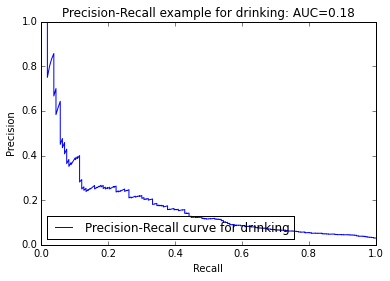

In [757]:
import glob
curClass = 'drinking'
lin_clf = trainClassifier(names,all_feats,curClass)
filePaths = glob.glob('/mnt/data/Stanford40/JPEGImages/'+curClass+'*.jpg')

array([-4.2179504 , -4.32261767, -4.25365705, -4.08618245, -1.65797589,
       -2.39011564, -3.93708625, -3.75951661, -2.40195695, -2.46553895,
       -4.02386385, -4.06217097])

number of boxes:  12
preprocessing : 0.0415141582489 seconds
running through net: 0.104978084564 seconds


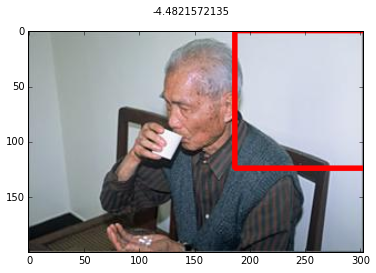

In [838]:
matplotlib.pyplot.close("all")
import time
ss = filePaths[0:1]
for i,f in enumerate(ss):
    img = caffe.io.load_image(f)
    h,out = processImage(img,2)
    p = out['fc6']
    u=lin_clf.decision_function(p)
    
    curInd = argmax(u) # descending order
    v = min(u)
    f = figure(i)
    clf()
    f.suptitle(str(v))
    curImg = img.copy()
    t = h[curInd,:]
    cv2.rectangle(curImg,tuple(t[0:2]),tuple(t[2:4]),(1,0,0),3)
    imshow(curImg)
    draw()
    

numpy.ndarray

In [762]:
#plot(u)
img_size = img.shape
print img_size

(400, 300, 3)


In [839]:
def boxCenters(boxes):
    x = (boxes[:,0:1]+boxes[:,2:3])/2    
    y = (boxes[:,1:2]+boxes[:,3:4])/2
    return concatenate((x,y),1)

In [841]:
def scale(a):
    a = a-min(a)
    a = a/max(a)
    return a

In [854]:
def multi(r,a,p=20):
    res = []
    
    a = a*p
    print a
    for i,t in enumerate(a):
        t = round(t)
        curRow = r[i:i+1,:]
        res.append(repeat(curRow,t,0))
    res = vstack(res)
    return res


In [855]:
u1 = scale(u)
print type(u1)
multi(h,u1)


<type 'numpy.ndarray'>
[  2.0054923    1.99623661   0.           6.6502802    4.06503681
   4.14832087  19.203993    14.99861666  12.65596093  20.          14.8188537
  17.11460508]


array([[  0,   0, 124, 124],
       [  0,   0, 124, 124],
       [  0,  62, 124, 186],
       [  0,  62, 124, 186],
       [ 62,   0, 186, 124],
       [ 62,   0, 186, 124],
       [ 62,   0, 186, 124],
       [ 62,   0, 186, 124],
       [ 62,   0, 186, 124],
       [ 62,   0, 186, 124],
       [ 62,   0, 186, 124],
       [ 62,  62, 186, 186],
       [ 62,  62, 186, 186],
       [ 62,  62, 186, 186],
       [ 62,  62, 186, 186],
       [ 62, 124, 186, 248],
       [ 62, 124, 186, 248],
       [ 62, 124, 186, 248],
       [ 62, 124, 186, 248],
       [124,   0, 248, 124],
       [124,   0, 248, 124],
       [124,   0, 248, 124],
       [124,   0, 248, 124],
       [124,   0, 248, 124],
       [124,   0, 248, 124],
       [124,   0, 248, 124],
       [124,   0, 248, 124],
       [124,   0, 248, 124],
       [124,   0, 248, 124],
       [124,   0, 248, 124],
       [124,   0, 248, 124],
       [124,   0, 248, 124],
       [124,   0, 248, 124],
       [124,   0, 248, 124],
       [124,  

[ 0.10027462  0.09981183  0.          0.33251401  0.20325184  0.20741604
  0.96019965  0.74993083  0.63279805  1.          0.74094269  0.85573025]


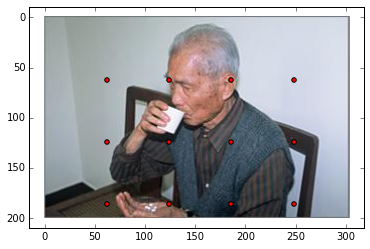

In [842]:

imshow(img)
c = boxCenters(h)
scatter(c[:,0],c[:,1],c='r')





In [769]:
import heatmap
import random



pts = [(random.random(), random.random()) for x in range(500)]
hm = heatmap.Heatmap()
hm.heatmap(pts, area=((-0.25, -0.25), (1.25, 1.25)))

#.save("classic.png")



<PIL.Image.Image image mode=RGBA size=1024x1024 at 0x7F878FFBBCB0>